In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Settings
pd.options.display.max_rows = 999

# Load data
df = pd.read_csv('data/TSLA.csv')

# Convert date to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Set date as index
df.set_index('Date', inplace=True)

# Calculate the end of week dates
df['Week'] = df.index.to_series().dt.isocalendar().week
df['Year'] = df.index.to_series().dt.isocalendar().year
df['Month'] = df.index.month  # Add Month column
df['DateStr'] = df.index.strftime('%y%m%d')
df['TradingWeek'] = (
    df['Year'].astype(str) + '-' 
    + df['Week'].astype(str).apply(lambda x: str(x).zfill(2))
)

# Filter out the end trading day of each week
weekly_df = df.groupby('TradingWeek').last()

# Calculate the last Friday's close price
weekly_df['PrevClose'] = weekly_df['Adj Close'].shift(1)

# Initialize the profit column
weekly_df['Profit'] = 0.0

# Calculate profit or loss for each week for call options
strike_factor = 1.15
premium = 0.005
leverage = 3
for i in range(333, len(weekly_df)):
    # Calculate the close price change for each week
    weekly_df.loc[weekly_df.index[i], 'CloseChange%'] = (
        (weekly_df.loc[weekly_df.index[i], 'Close'] - weekly_df.loc[weekly_df.index[i-1], 'Close']) 
        / weekly_df.loc[weekly_df.index[i-1], 'Close']) * 100

    # If the previous stock close price decrease change the strike factor back to 1.15
    if i > 1 and weekly_df.loc[weekly_df.index[i], 'CloseChange%'] < 0:
        strike_factor = 1.2

    # Increase the strike factor if the last week's price change is greater than 10%
    if weekly_df.loc[weekly_df.index[i-1], 'CloseChange%'] > 10:
        strike_factor = 1.25

    # Increase the strike factor if the last week's price change is greater than 10%
    if weekly_df.loc[weekly_df.index[i-1], 'CloseChange%'] > 15:
        strike_factor = 1.3

    # Increase the strike factor at the start of each quarter
    if weekly_df.loc[weekly_df.index[i], 'Month'] in [1, 4, 7, 10]:
        strike_factor = 1.3

    prev_close = weekly_df.loc[weekly_df.index[i-1], 'Adj Close']
    this_close = weekly_df.loc[weekly_df.index[i], 'Adj Close']
    if this_close <= prev_close * strike_factor:
        profit = prev_close * premium
    else:
        profit = prev_close * premium - leverage * (this_close - prev_close * strike_factor)
    weekly_df.loc[weekly_df.index[i], 'Profit'] = profit

weekly_df['CumulativeProfit'] = weekly_df['Profit'].cumsum()

# Select only necessary columns
output_df = weekly_df[['DateStr', 'PrevClose', 'Close', 
                       'CloseChange%', 'Profit', 'CumulativeProfit']].reset_index()
# output_df['Volatility'] = output_df['CloseChange%'].rolling(3).median()

# df_loss = output_df[output_df['Profit']<0]
# df_loss

output_df[::5]

,TradingWeek,DateStr,PrevClose,Close,CloseChange%,Profit,CumulativeProfit
0,2010-26,100702,NaN,1.280000,NaN,0.000000,0.000000
5,2010-31,100806,1.329333,1.306000,NaN,0.000000,0.000000
10,2010-36,100910,1.403333,1.344667,NaN,0.000000,0.000000
15,2010-41,101015,1.362000,1.369333,NaN,0.000000,0.000000
20,2010-46,101119,1.989333,2.066000,NaN,0.000000,0.000000
25,2010-51,101223,2.090667,2.006000,NaN,0.000000,0.000000
30,2011-04,110128,1.536000,1.600667,NaN,0.000000,0.000000
35,2011-09,110304,1.574000,1.663333,NaN,0.000000,0.000000
40,2011-14,110408,1.777333,1.766000,NaN,0.000000,0.000000
45,2011-19,110513,1.808000,1.836667,NaN,0.000000,0.000000


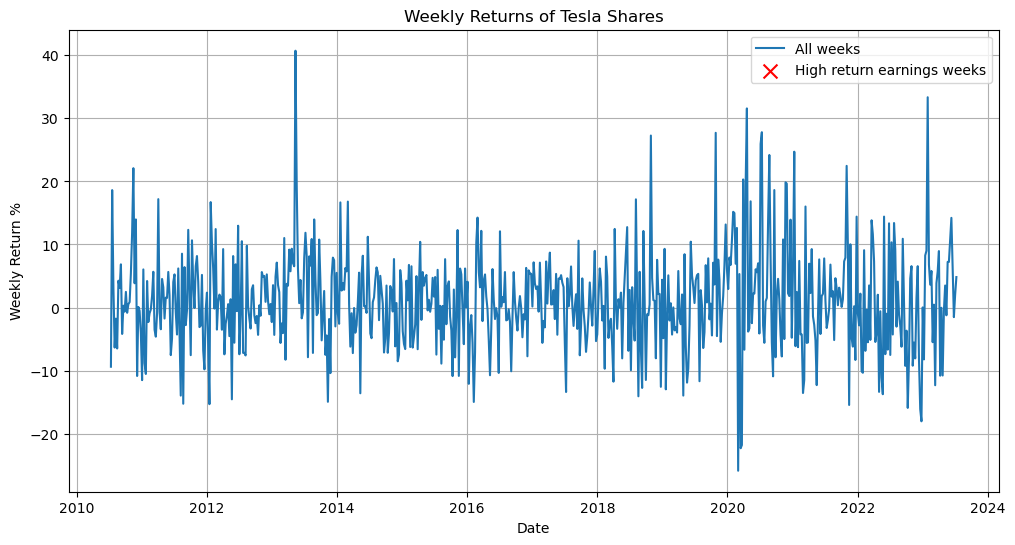

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the data
data = pd.read_csv('data/TSLA.csv', parse_dates=['Date'], index_col='Date')

# Resample to get weekly data
weekly_data = data.resample('W').last()

# Calculate the weekly return
weekly_data['Prev Week Close'] = weekly_data['Close'].shift(1)
weekly_data['Weekly Return %'] = (weekly_data['Close'] / weekly_data['Prev Week Close'] - 1) * 100

# Identify the weeks with a return greater than 15%
high_return_weeks = weekly_data[weekly_data['Weekly Return %'] > 15]

# Earnings dates
earnings_dates = pd.to_datetime([
    '7/19/23', '4/19/23', '1/25/23', '10/19/22', '7/20/22', '4/20/22', '1/26/22', '10/20/21', 
    '7/26/21', '4/26/21', '1/27/21', '10/21/20', '7/22/20', '4/29/20', '1/29/20', '10/23/19', 
    '6/24/19', '4/24/19', '1/30/19', '10/24/18', '8/1/18', '5/2/18', '2/7/18', '11/1/17', 
    '8/2/17', '5/3/17', '2/22/17', '10/26/16', '8/3/16', '5/4/16'
])

# Function to get the closest following week for each earnings date
def closest_following_week(date):
    if date > weekly_data.index[-1]:
        return None
    while date not in weekly_data.index:
        date += pd.Timedelta(days=1)
    return date

# Weeks that are both high return weeks and have earnings dates
high_return_earnings_weeks = weekly_data.loc[high_return_weeks.index.intersection(earnings_dates)]

# High return weeks that do not have earnings dates
high_return_non_earnings_weeks = high_return_weeks[~high_return_weeks.index.isin(earnings_dates)]

# Plot the weekly returns, highlighting the earnings weeks
plt.figure(figsize=(12, 6))
plt.plot(weekly_data.index, weekly_data['Weekly Return %'], label='All weeks')
plt.scatter(high_return_earnings_weeks.index, high_return_earnings_weeks['Weekly Return %'], 
            color='red', label='High return earnings weeks', marker='x', s=100)
plt.title('Weekly Returns of Tesla Shares')
plt.xlabel('Date')
plt.ylabel('Weekly Return %')
plt.legend()
plt.grid()
plt.show()
